# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [7]:
# Python Standard Library
# -----------------------
pass

In [8]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [9]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [10]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [11]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [12]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [13]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [14]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

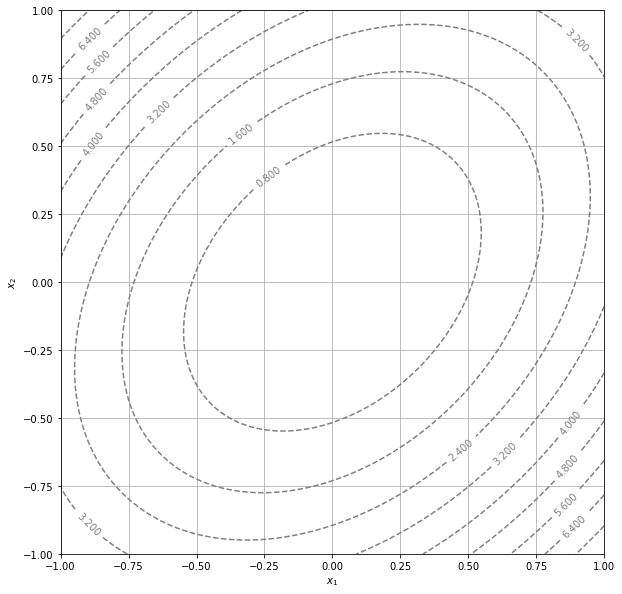

In [15]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [16]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

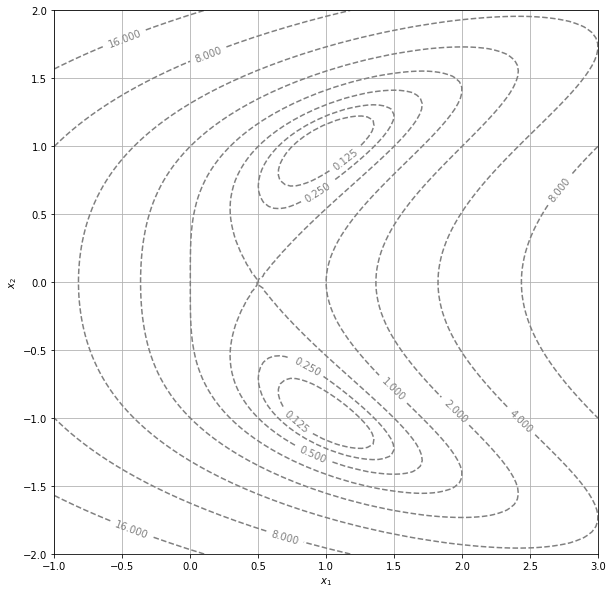

In [17]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [18]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

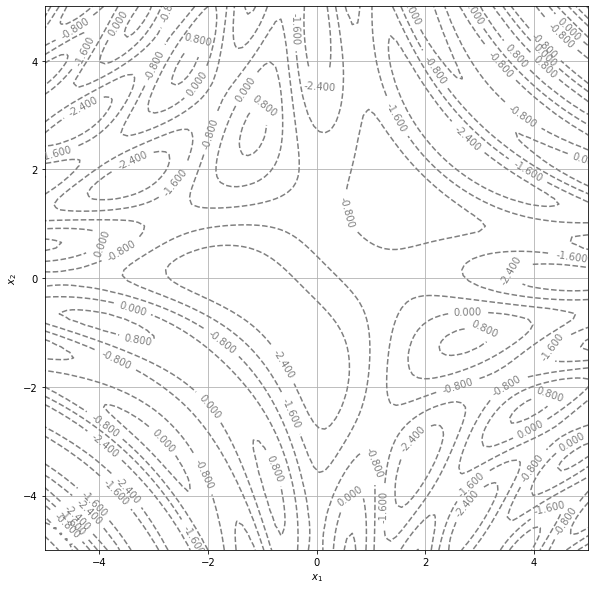

In [19]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse
Notons $E$ cet ensemble.

($ \imath)$ $E$ est fermé : en effet, $E = f^-1(\lbrace c \rbrace) $ est l'image réciproque d'un fermé (singleton) par $ f $ qui est continue. 

($ \imath \imath$) $E$ est borné : en effet, comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, il existe $B$$\in \mathbb{R}$ tel que pour tout $(x_1,x_2)\in\mathbb{R}^2$ vérifiant $\|(x_1,x_2)\| \geq B$, $\|f(x_1,x_2)\|\geq c+1$. Ainsi, si $ (x_1,x_2)\in E$, nécessairement, $\|(x_1,x_2)\| \leq B$, d'ou le caractère borné de $E$.

Ainsi $E$ est un compact (dimension finie).

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse
$p(x_1,x_2)$ est produit scalaire de $x-x_0$ (en posant $x = (x_1,x_2)$) par un vecteur directeur unitaire de la droite tangente à la courbe de niveau en $x_0$.
En effet, la droite normale à la courbe de niveau en $x_0$ a pour vecteur directeur : \begin{pmatrix}{\partial_1 f(x_0)} \\ {\partial_2 f(x_0)} \end{pmatrix}
La droite tangente a donc pour vecteur directeur :
$\frac{1}{\|\nabla f(x_0)\|} \begin{pmatrix}{\partial_2 f(x_0)} \\ {-\partial_1 f(x_0)} \end{pmatrix} $

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse
Posons $g : (x,t) \in \mathbb{R}^2\times \mathbb{R} \mapsto (f(x)-c,p(x)-t) \in \mathbb{R}^2$.
$g$ est continuement différentiable (ses composantes sont fonctions de $f$ et $p$ qui sont elles mêmes continuement différentiables).
Pour $(x,t) \in \mathbb{R}^2\times \mathbb{R}$, 
$$
det(\partial_x g(x))  = 
\begin{vmatrix} \partial_1 f(x) & \partial_2 f(x) \\ \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & \frac{-\partial_1 f(x_0)}{\|\nabla f(x_0)\|}\end{vmatrix} 
= -\frac{\partial_1 f(x_0) \cdot \partial_1 f(x) + \partial_2 f(x_0) \cdot \partial_2 f(x)}{\|\nabla f(x_0)\|}
$$
Ainsi, $det(\partial_x g(x_0)) = - \| \nabla f(x_0)\| \ne 0 $.
Donc par continuité du déterminant, $\lvert \partial g(x) \rvert $ ne s'annule pas dans un voisinage de $x_0$. On a donc que $\partial_x g$ est inversible dans un voisinage de $x_0$.
De plus, $g(x_0,0) = (f(x_0)-c, p(x_0)) = (0,0) = 0_{\mathbb{R}^2}$.

Par le théorème des fonctions implicites, il existe donc $U$ et $V$ voisinages ouverts de (respectivement) $x_0$ et $0$ et $\gamma : V \to \mathbb{R}^2$ continuement différentiable telle que :
$$
\forall x = (x_1,x_2) \in U, \forall t \in V :
 \left\{
    \begin{array}{ll}
        f(x_1,x_2) = c \\
        p(x_1,x_2)=t
    \end{array}
\right.
(\Leftrightarrow g(x,t) = 0)
\Leftrightarrow x = \gamma(t)
$$
(on peut alors trouver un $\varepsilon$ positif qui convient par définition de l'ouvert V)


#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse

$( \imath)$ Posons $\phi :(x_1,x_2) \in W \mapsto \gamma(p(x_1,x_2))=(x_1,x_2)$
où $W = U \cap \gamma(]-\varepsilon;\varepsilon[)$ (ouvert en tant qu'intersection de deux ouverts)

On a l'égalité $\gamma(p(x_1,x_2))=(x_1,x_2)$ sur $W$ d'après le résultat de la question 3.

Pour $(x_1,x_2) \in W$, on a : $d \phi (x_1,x_2) = d(Id) = Id_{W} $ 

Soit $t \in ]- \varepsilon; \varepsilon[$. Notons $(x_1,x_2) = \gamma(t) \in W$
On a, toujours par la Q3, $t=p(x_1,x_2)$ et $Id_{W} = d\phi (x_1,x_2) = \gamma'(t) \cdot dp(x_1,x_2)$
Donc nécessairement $\gamma'(t) \neq 0$.

$( \imath \imath)$ Pour $t \in ]-\varepsilon;\varepsilon[, f(\gamma(t)) = c$

Donc $ 0= (f \circ \gamma)'(t) = \gamma'(t) \cdot \nabla f( \gamma(t))$
Donc $\gamma'(t)$ est orthogonal à $\nabla f(\gamma(t))$



## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

#### Réponse
N = 100
eps = $10^{-10}$

Pour initialiser la courbe de niveau, il vaut mieux avoir une grande precision.

On peut prendre $10^{-10}$ qui offre une excellente précision tout en étant supérieur à l'approximation des doubles : $2^{-52} \simeq 2.2 \cdot 10^{-16}$

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [41]:
def Newton(F, xi, yi, eps=10**(-10), N=10000) :
    JF = J(F)
    x0, y0 = xi, yi
    for i in range(N):
        temp = np.dot(np.linalg.inv(JF(x0, y0)),F(x0, y0))
        x, y = x0 - temp[0], y0 - temp[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps : # écart infime entre deux points successifs (< eps)
                                                       # donc l'approximation de base de la méthode de Newton 
                                                       # est vérifiée : on a approximé une solution
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [42]:
def f(x1,x2):
    return np.array([f1(x1,x2)-0.8,x1-x2])

In [43]:
res=Newton(f, 0.8, 0.9)
print("res =",res)
f1(res[0],res[1])

res = (0.447213595499958, 0.447213595499958)


0.8000000000000003

Text(0, 0.5, 'x2')

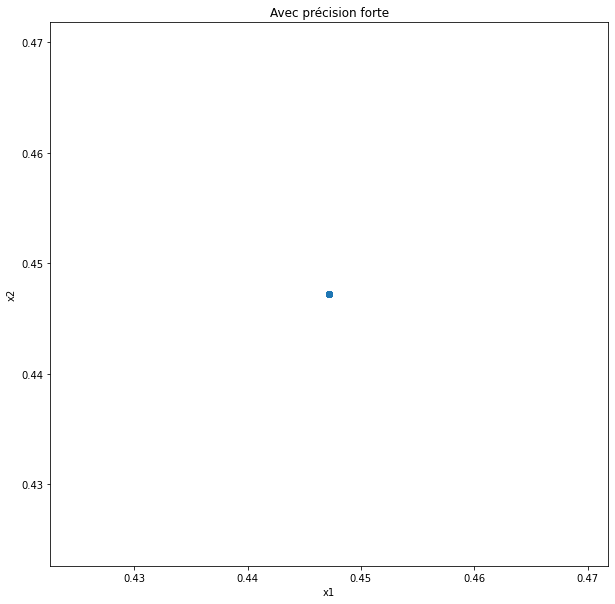

In [62]:
x0=np.linspace(0.7,0.9,100)
y0=np.linspace(0.7,0.9,100)[::-1]
res1=np.zeros(200).reshape(100,2)
for i in range(100) :
    res1[i] = Newton(f, x0[i], y0[i])

plt.scatter(res1[::,0],res1[::,1])
plt.title('Avec précision forte')
plt.xlabel('x1')
plt.ylabel('x2')

Le choix du point de départ n'a pas d'importance dans un voisiage d'un point qui satisfait l'équation avec la précision que l'on a fixé (très grande).

0.8001311534773976

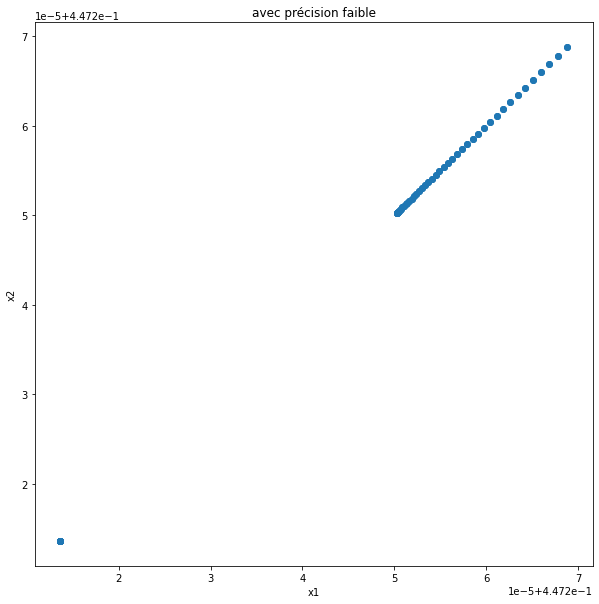

In [59]:
x0=np.linspace(0.7,0.9,100)
y0=np.linspace(0.7,0.9,100)[::-1]
res1=np.zeros(200).reshape(100,2)
for i in range(100) :
    res1[i] = Newton(f, x0[i], y0[i], 10**(-2))

plt.scatter(res1[::,0],res1[::,1])
plt.title('Avec précision faible')
plt.xlabel('x1')
plt.ylabel('x2')

f1(res1[50][0],res1[50][1])

Avec une précision faible, on obtient des points différents, mais qui ne sont pas tout à fait solution de $f(x_1,x_2) = 0,8 $

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

#### Réponse
On peut appliquer la méthode de Newton en initialisant au point $(x_1,y_1)$ à une distance $\delta$ de $(x_0,y_0)$ dans la direction correspondant à la droite de celle du grandient en $(x_0,y_0)$ de $f$.

Ce point est : 
$\begin{pmatrix}
x_1 \\
y_1
\end{pmatrix} 
= \begin{pmatrix}
x_0 + \delta \cdot \frac{\partial_2 f(x_0,y_0)}{\|\nabla f(x_0,y_0)\|} \\
y_0 - \delta \cdot \frac{\partial_1 f(x_0,y_0)}{\|\nabla f(x_0,y_0)\|}
\end{pmatrix}$

(On vérifie aisément que $\|(x_1-x_0,y_1-y_0)\| = \delta $).

On cherche à obtenir un point $(x,y)$ vérifiant $f(x,y) = c$ et $\|(x-x_0,y-y_0)\| = \delta $

À chaque point généré par l'itération, on réapliquera l'itération suivante en appliquant l'algorithme de Newton au point $(x_{i+1},y_{i+1})$ obtenu de $(x_i,y_i)$ par la même transformation qui donne $(x_1,y_1)$ grâce à $(x_0, y_0)$.

On posera ainsi :

$F:(x,y) \mapsto (f(x,y)-c, (x-x_i)^2 + (y-y_i)^2 - \delta ^2)$

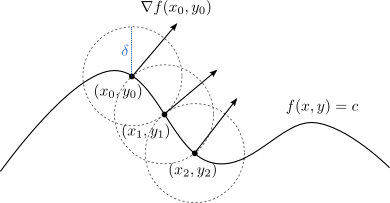

In [23]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=10**(-10)):
    res = np.zeros(2*N).reshape(2, N)
    c = f(x0, y0)
    Jf = J(f)
    res[0,0], res[1,0] = (x0, y0)
    for i in range(1,N):
        x1, y1 = res[0,i-1], res[1,i-1]
        def F(x,y):    # l'algo de Newton appliqué à f permettra de 
                       # remplir les 2 conditions (=c et distance delta)
            return np.array([f(x,y)-c, (x-x1)**2+(y-y1)**2-delta**2])
        nrm = np.linalg.norm(Jf(x1, y1))
        xi = x1 + delta*((Jf(x1, y1))[1])/nrm
        yi = y1 - delta*((Jf(x1, y1))[0])/nrm
        prc = Newton(F, xi, yi, eps, N)
        xi, yi = prc[0], prc[1]
        res[0,i], res[1,i] = (xi, yi)
    return res

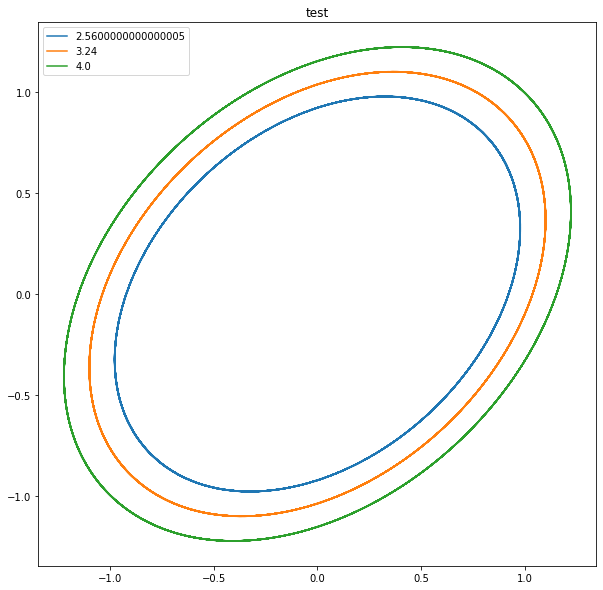

In [75]:
test1=level_curve(f1, 0.8, 0.8, 0.1, 1000)
test2=level_curve(f1, 0.9, 0.9, 0.1, 1000)
test3=level_curve(f1, 1.0, 1.0, 0.1, 1000)

plt.figure()
plt.title('test')
plt.plot(test1[0],test1[1], label=f1(0.8,0.8))
plt.plot(test2[0],test2[1], label=f1(0.9,0.9))
plt.plot(test3[0],test3[1], label=f1(1.0,1.0))
plt.legend()

56.5625

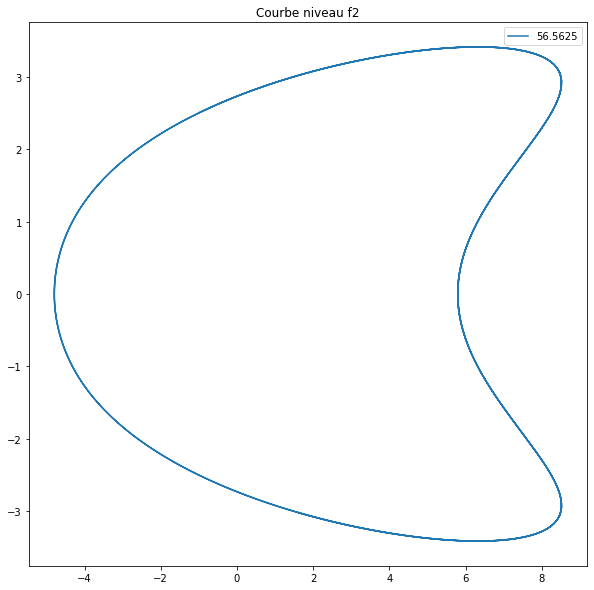

In [69]:
test=level_curve(f2, -1.0, 2.5, 0.1, 1000)

plt.title('Courbe niveau f2')
plt.plot(test[0],test[1], label=f2(-1.0, 2.5))
plt.legend()
f2(-1.0, 2.5)

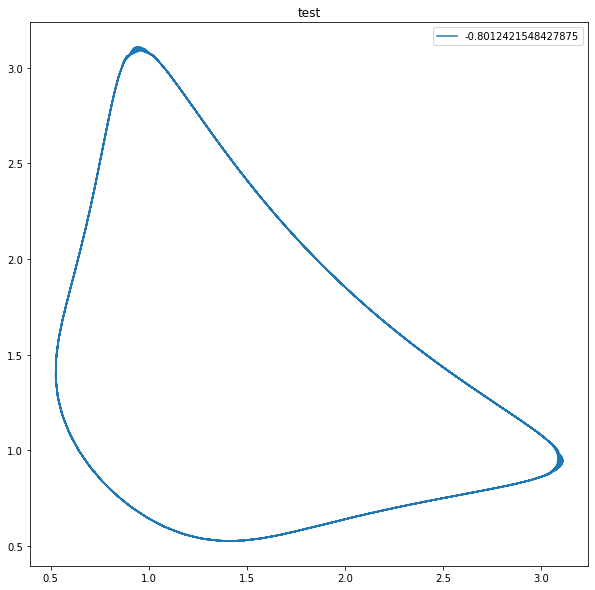

In [71]:
test=level_curve(f3, 0.8, 0.8, 0.1, 1000)

plt.title('test')
plt.plot(test[0],test[1], label=f3(0.8,0.8))
plt.legend()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

Il faut, pour que l'on se retrouve dans une configuration similaire à celle de Rosenbrock, que la courbe de niveau ait une forme de "selle". L'ensembles fonctions ayant une telle forme est à priori négligeable par rapport à l'ensembles des fonctions de $\mathbb{R} ^2$ dans $\mathbb{R} $.

Les fonctions à courbes de niveau auto-intersectantes sont donc "rares". Tester l'intersection de tous les segments n'étant nécessaire que sur une courbe de niveau auto-intersectante, en étant optimiste, on peut considérer qu'il est suffisant de ne tester que l'intersection du dernier et du premier segment.

In [24]:
def intersection(x1, y1, x2, y2, a1, b1, a2, b2):
    cfx=(y2-y1)/(x2-x1)
    cfa=(b2-b1)/(a2-a1)
    if cfx == cfa :
        return False
    cstx=y1-cfx*x1
    csta=b1-cfa*a1
    x=(cstx-csta)/(cfa-cfx)
    if (min(x1,x2)<x<max(x1,x2) and min(a1,a2)<x<max(a1,a2)):
        return True
    return False

def level_curve2(f, x0, y0, delta=0.1, N=1000, eps=10**(-10)):
    res = np.zeros(2*N).reshape(2, N)
    c = f(x0, y0)
    Jf = J(f)
    res[0,0], res[1,0] = (x0, y0)
    bool = True
    i = 1
    while (i<N and bool):
        x1, y1 = res[0,i-1], res[1,i-1]
        def F(x,y):
            return np.array([f(x,y)-c, (x-x1)**2+(y-y1)**2-delta**2])
        nrm = np.linalg.norm(Jf(x1, y1))
        xi = x1 + delta*((Jf(x1, y1))[1])/nrm
        yi = y1 - delta*((Jf(x1, y1))[0])/nrm
        prc = Newton(F, xi, yi, eps, N)
        xi, yi = prc[0], prc[1]  #on peut symplifier l'écriture
        res[0,i], res[1,i] = xi, yi
        if (i>1 and intersection(res[0,0], res[1,0], res[0,1], res[1,1], res[0,i-1], res[1,i-1], res[0,i], res[1,i])):
            print(i) #pour savoir quand s'arrête la boucle
            bool = False
        i += 1
    while i<N :  #décaler dans le while précédent, avant le if ?
            res[0,i], res[1,i] = res[0,i-1], res[1,i-1] #pour finir de remplir le tableau avec des valeurs correctes
            i += 1
    return res

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 

Posons : $P1= \gamma (0) = \begin{pmatrix}
x_1 \\
y_1
\end{pmatrix} $ , $ P2 = \gamma (1) = \begin{pmatrix} 
x_2 \\
y_2 
\end{pmatrix} $, 
$ \gamma'(0) = \lambda_1 u_1 = \lambda_1 
\begin{pmatrix}
v_1 \\
w_1
\end{pmatrix} $,
$\gamma'(1) = \lambda_2 u_2 = \lambda_2 
\begin{pmatrix}
v_2 \\
w_2
\end{pmatrix} $

Traduisons les conditions imposées par le problème  

en $0$ :$
 \left\{
    \begin{array}{ll}
        x(0) = a = x_1 \\
        x'(0) = b = \lambda_1 v_1 \\
        y(0) = d = y_1 \\
        y'(0) = e = \lambda_1 w_1 \\
    \end{array}
\right.
$       et en $1$ :    $
  \left\{
      \begin{array}{ll}
        x(1) = a + b + c = x_2 \\
        x'(1) = b + 2c = \lambda_2 v_2 \\
        y(1) = d + e + f = y_2 \\
        y'(1) = e + 2f = \lambda_2 w_2
    \end{array}
   \right.
$

On a donc déjà $a$ et $d$ qui sont fixés.

En travaillant sur ces équations, on obtient le système équivalent : 
$
  \left\{
      \begin{array}{ll}
        c = x_2 - x_1 - \lambda_1 v_1 \\
        f = y_2 - y_1 - \lambda_1 ww_1 \\
        b = \lambda_1 v_1 \;\;\;\; e = \lambda_1 w_1 \\
        b + 2 c = \lambda_2 v_2 \;\;\;\; e + 2f = \lambda_2 w_2 \\
    \end{array}
   \right.
$

Dont les lignes 1, 2, et 4 impliquent que : 

$
2
\begin{pmatrix}
x_2 - x_1 \\
y_2 - y_1
\end{pmatrix}
$
$=$
$
\begin{pmatrix}
-v_1 \;\;\;\; v_2 \\
-w_1 \;\;\;\; w_2 
\end{pmatrix}
$
$\cdot$
$
\begin{pmatrix}
\lambda_1 \\
\lambda_2
\end{pmatrix}
$

(on conserve l'équivalence en écrivant cette équation matricielle, ainsi que les lignes 1, 2 et 3 du système)

On a alors 2 cas qui se présentent, selon que $u_1$ et $u_2$ sont ou non colinéaires :

($\imath$) $u_1$ et $u_2$ ne sont pas colinéaires :

La matrice 
$
\begin{pmatrix}
-v_1 \;\;\;\; v_2 \\
-w_1 \;\;\;\; w_2 
\end{pmatrix}
$
est alors inversible et on trouve alors : 

$\lambda_1 = 2 \frac{ w_2 \cdot(x_2 - x_1)- v_2 \cdot (y_2 - y_1)}{w_1 \cdot v_2 - w_2 \cdot v_1 } $ et 
$\lambda_2 = 2 \frac{ w_1 \cdot(x_2 - x_1)- v_1 \cdot (y_2 - y_1)}{w_1 \cdot v_2 - w_2 \cdot v_1 } $

Si $\lambda_1$ ou $\lambda_2$ est négatif, il n'y a pas de solutions au problème posé (car on cherche à ce que les dérivées de $\gamma$ en $0$ et en $1$ soient dans le même sens que $u_1$ et $u_2$.

Sinon, on a donc $\lambda_1$ et $\lambda_2$ en fonction des paramètres du problème. On trouve alors $b$ et $e$ en fonction de ces mêmes paramètres, puis $c$ et $f$.

($\imath \imath$) $u_1$ et $u_2$ sont colinéaires :

On pose par exemple $u_2 = \alpha u_1$

On trouve alors la condition : 
$
  \left\{
      \begin{array}{ll}
        2 \cdot (x_2 - x_1) = (\lambda_1 + \alpha \lambda_2) \cdot v_1 \\
        2 \cdot (y_2 - y_1) = (\lambda_1 + \alpha \lambda_2) \cdot w_1\\
    \end{array}
   \right.
$

Ce qui signifie que $\overrightarrow{P_1P_2}$ est colinéaire à $u_1$ et $u_2$.






#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [25]:
def gamma(t, P1, P2, u1, u2):
    if np.linalg.det([u1, u2])==0 :
        def gam1(x):
            return np.array([P2[0]*x+P1[0]*(1-x), P2[1]*x+P1[1]*(1-x)])
        return gam1(t)
    else:
        a=P1[0]
        d=P2[0]
        l1=(2*u2[1]*(P2[0]-P1[0])-2*u2[0]*(P2[1]-P1[1]))/(u1[0]*u2[1]-u1[1]*u2[0])
        if u2[1]==0:
            l2=(2*(P2[0]-P1[0])-l1*u1[0])/u2[0]
        else:
            l2=(2*(P2[1]-P1[1])-l1*u1[1])/u2[1]
        print (l1, l2)
        if l1<0 or l2<0:
            def gam2(x):
                return np.array([P2[0]*x+P1[0]*(1-x), P2[1]*x+P1[1]*(1-x)])
            return gam2(t)
        b=l1*u1[0]
        e=l1*u1[1]
        c=P2[0]-b-a
        f=P2[1]-e-d
        def gam3(x):
            return np.array([a+b*x+c*(x**2), d+e*x+f*(x**2)])
        return gam3(t)


### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [26]:
def normal_to_directeur(u):
    return np.array([u[1],-u[0]])

def level_curve3(f, x0, y0, delta=0.1, N=1000, eps=10**(-10), oversampling=1):
    res = np.zeros(2*N*oversampling).reshape(2, N*oversampling)
    c = f(x0, y0)
    Jf = J(f)
    res[0,0], res[1,0] = (x0, y0)
    bool = True
    i = 0
    while (i<=(N-1)*oversampling and bool):
        i += 1
        x1, y1 = res[0,(i-1)*oversampling], res[1,(i-1)*oversampling]
        def F(x,y):
            return np.array([f(x,y)-c, (x-x1)**2+(y-y1)**2-delta**2])
        nrm = np.linalg.norm(Jf(x1, y1))
        xi = x1 + delta*((Jf(x1, y1))[1])/nrm
        yi = y1 - delta*((Jf(x1, y1))[0])/nrm
        prc = Newton(F, xi, yi, eps, N)
        xi, yi = prc[0], prc[1]
        res[0,i*oversampling], res[1,i*oversampling] = xi, yi
        if oversampling>1:
            t=np.linspace(0,1,oversampling+1)
            grad_f=grad(f)
            #print(res[::,(i-1)*oversampling:i*oversampling+1])
            res[::,(i-1)*oversampling:i*oversampling+1]=Gamma(t,np.array([x1,y1]),np.array([xi,yi]),normal_to_directeur(grad_f(x1,y1)),normal_to_directeur(grad_f(xi,yi)))
            #print(t,np.array([x1,y1]),np.array([xi,yi]),normal_to_directeur(grad_f(x1,y1)),normal_to_directeur(grad_f(xi,yi)))
            #print(res[::,(i-1)*oversampling:i*oversampling+1])
        if (i>1 and intersection(res[0,0], res[1,0], res[0,oversampling], res[1,oversampling], res[0,(i-1)*oversampling], res[1,(i-1)*oversampling], res[0,i*oversampling], res[1,i*oversampling])):
            print(i) #pour savoir quand s'arrête la boucle
            bool = False
        #print("\n")
    print(i*oversampling)
    while i<N :
        for j in range(oversampling):
            res[0,i*oversampling+j], res[1,i*oversampling+j] = res[0,(i-1)*oversampling], res[1,(i-1)*oversampling] #pour finir de remplir le tableau avec des valeurs correctes
            #print(res[0,i*oversampling+j], res[1,i*oversampling+j])
        i += 1
    return res

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.